PCA차원수 줄이기. 정규화하기.  


# 비상장 중소기업의 상장 후 주가 예측 프로젝트

이 프로젝트는 비상장 중소기업의 상장 후 주가 예측 프로젝트다. 과거 중소기업이 상장 후 주가의 산술평균을 타겟값으로 지도 학습 알고리즘을 사용할 것이다.

기본설정

In [1]:
import numpy as np 
import os  
import matplotlib ##그림용
import matplotlib.pyplot as plt ##그림용
import sklearn ##사이킷런
import pandas as pd

np.random.seed(42) ##랜덤시드 

matplotlib.rc('font', family='NanumBarunGothic') ##matplotlib 한글을 위해
plt.rcParams['axes.unicode_minus'] = False ##한글을 위해

In [2]:
data = pd.read_csv('datasets//DB//DB_data.csv', engine='python')

# 기업규모명

우리가 예측하고 싶은 대상은 중소기업이므로 중소기업만 관찰한다.

In [3]:
data = data[data["기업규모명"] == '중소기업']

데이터를 간략하게 살펴보자

In [4]:
data.head()

,회사명,회계년도,산업명,소속코드,설립일,종업원,당좌자산(*),재고자산(*),비유동자산(*),유동부채(*),...,환율변동으로 인한 차이조정,현금의 증가(감소)(*),기업규모명,산술평균,경제성장률,총저축률,제조업 평균가동률,실업률,코스피지수,경상수지
0,(주)CMG제약,2011-03-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,9917659.0,3104211.0,15477735.0,4969819.0,...,0.0,-265171.0,중소기업,873.0,1.0,34.1,81.3,4.2,1939.30,-4253.0
1,(주)CMG제약,2011-06-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,11341653.0,3071427.0,14731279.0,5976935.0,...,0.0,-1160724.0,중소기업,577.0,0.6,34.1,80.6,3.4,2142.47,-2470.6
2,(주)CMG제약,2011-09-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,11407699.0,3352328.0,14717723.0,6389723.0,...,0.0,-1961689.0,중소기업,993.0,0.7,34.8,80.9,3.1,1880.11,11405.6
3,(주)CMG제약,2011-12-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,12521782.0,2743103.0,12283654.0,7620349.0,...,-14.0,-1294857.0,중소기업,775.0,0.6,35.2,79.3,2.9,1847.51,11956.2
4,(주)CMG제약,2012-03-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,13370740.0,3654331.0,12100895.0,8146944.0,...,-306.0,435947.0,중소기업,892.0,0.5,34.3,79.7,3.8,2045.08,-1292.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21047 entries, 0 to 47822
Data columns (total 40 columns):
회사명                  21047 non-null object
회계년도                 21047 non-null object
산업명                  20908 non-null object
소속코드                 20908 non-null float64
설립일                  20908 non-null object
종업원                  20908 non-null float64
당좌자산(*)              20615 non-null float64
재고자산(*)              20615 non-null float64
비유동자산(*)             20615 non-null float64
유동부채(*)              20615 non-null float64
비유동부채(*)             20615 non-null float64
자본금(*)               20615 non-null float64
자본잉여금(*)             20615 non-null float64
자본조정(*)              20615 non-null float64
기타포괄손익누계액(*)         20615 non-null float64
이익잉여금(*)             20615 non-null float64
매출액(영업수익)(*)         20615 non-null float64
매출원가(*)              20615 non-null float64
매출총이익(손실)            20615 non-null float64
판매비와관리비(영업비용)(*)     20615 non-null float64
영업이익(손실)       

# 파일 정제

결측치가 몇 개 보인다.  산술평균에 경우 우리의 타겟값이므로 산술평균의 결측치가 있는 경우 객체를 버린다.

In [6]:
data = data[-(data["산술평균"].isnull())]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19416 entries, 0 to 47822
Data columns (total 40 columns):
회사명                  19416 non-null object
회계년도                 19416 non-null object
산업명                  19416 non-null object
소속코드                 19416 non-null float64
설립일                  19416 non-null object
종업원                  19416 non-null float64
당좌자산(*)              19145 non-null float64
재고자산(*)              19145 non-null float64
비유동자산(*)             19145 non-null float64
유동부채(*)              19145 non-null float64
비유동부채(*)             19145 non-null float64
자본금(*)               19145 non-null float64
자본잉여금(*)             19145 non-null float64
자본조정(*)              19145 non-null float64
기타포괄손익누계액(*)         19145 non-null float64
이익잉여금(*)             19145 non-null float64
매출액(영업수익)(*)         19145 non-null float64
매출원가(*)              19145 non-null float64
매출총이익(손실)            19145 non-null float64
판매비와관리비(영업비용)(*)     19145 non-null float64
영업이익(손실)       

이 경우 결측치가 있는 데이터가 소수일 것이라 생각되어 결측치가 있는 데이터를 버리는 것이 좋을 것 같다.

In [7]:
data = data[-data["당좌자산(*)"].isnull()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19145 entries, 0 to 47822
Data columns (total 40 columns):
회사명                  19145 non-null object
회계년도                 19145 non-null object
산업명                  19145 non-null object
소속코드                 19145 non-null float64
설립일                  19145 non-null object
종업원                  19145 non-null float64
당좌자산(*)              19145 non-null float64
재고자산(*)              19145 non-null float64
비유동자산(*)             19145 non-null float64
유동부채(*)              19145 non-null float64
비유동부채(*)             19145 non-null float64
자본금(*)               19145 non-null float64
자본잉여금(*)             19145 non-null float64
자본조정(*)              19145 non-null float64
기타포괄손익누계액(*)         19145 non-null float64
이익잉여금(*)             19145 non-null float64
매출액(영업수익)(*)         19145 non-null float64
매출원가(*)              19145 non-null float64
매출총이익(손실)            19145 non-null float64
판매비와관리비(영업비용)(*)     19145 non-null float64
영업이익(손실)       

결측치가 있는 데이터가 없다.

# 머신러닝에 넣기 위해 데이터를 전처리하자.

train 데이터와 test 데이터를 나누자.

In [8]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(data, test_size=0.2, random_state=42)

test의 경우 나중에 모델을 평가할 때 사용하자.

In [9]:
labels = train["산술평균"]
train.drop(["산술평균"], axis=1, inplace=True)

c:\users\student\documents\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


주어진 미시 변수에 경우 서로의 상관관계가 높을 것이라 생각되어, PCA알고리즘을 이용하여 차원을 줄이도록 하자.

In [10]:
micro_val = ['당좌자산(*)','재고자산(*)','비유동자산(*)','유동부채(*)','비유동부채(*)',
        '자본금(*)','자본잉여금(*)','자본조정(*)','기타포괄손익누계액(*)',
        '이익잉여금(*)','매출액(영업수익)(*)','매출원가(*)','매출총이익(손실)',
        '판매비와관리비(영업비용)(*)','영업이익(손실)','영업외수익(*)','영업외비용(*)',
        '법인세비용차감전(계속사업)손익','(계속사업손익)법인세비용','계속사업이익(손실)',
        '당기순이익(순손실)','영업활동으로 인한 현금흐름(*)',
        '투자활동으로 인한 현금흐름(*)','재무활동으로 인한 현금흐름(*)',
       '환율변동으로 인한 차이조정','현금의 증가(감소)(*)']

X = train[micro_val]

먼저 주어진 데이터를 95%이상 설명가능한 차원의 수를 구하자.

In [11]:
from sklearn.decomposition import PCA

In [12]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_) ## 모든 배열의 원소들을 누적으로 다 더한 놈들 반환
d = np.argmax(cumsum>=0.90)+1 ## argmax는 제일 큰 수의 index를 1차원 배열로 봤을 때의 index로 반환
# d = 9
## 9차원이면 주어진 데이터를 95%이상 설명할 수 있다.
pca = PCA(n_components=d)

pca.fit_transform(X), d

(array([[-48247380.59715195,  -4110257.20150594,  20321826.25999282,
         -11334208.22744098,  -3497720.98940168,   6771370.38262977],
        [-65519713.17814296,  36031202.36165352,  10882457.37382337,
          16203447.47076818,  -4038338.81271905,  19454723.90746049],
        [ 48216688.23810559,  -8666658.02961184,  21388001.70162052,
          15692316.6731524 ,  -5577307.62608148,   6154644.91473092],
        ...,
        [-46611561.54192251,   -295671.43658584,  10516326.30176441,
          -4907924.63182414,  -2254015.47771291,   4123608.87358541],
        [-33783775.29316626,  13367791.86767786,   4226772.4127493 ,
           2615949.6464031 ,  -8925312.73879742,  -9590581.89061795],
        [-26906873.37999649, -42350844.83539637, -13730224.72352855,
         -22483767.76673504,  16028789.55327919,    208273.4719043 ]]), 6)

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class drop_some_attributes(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.drop(["회계년도","회사명"], axis=1)

class PCA_K2H(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        pca.fit(X[micro_val])
        return self
    def transform(self, X, y=None):
        self.index_ = X.index
        
        col = []
        for i in range(d):
            col.append('pca%s' %i)
        
        XdD = pd.DataFrame(pca.transform(X[micro_val]), 
                          index=self.index_, columns = col)
        
        X.drop(micro_val, axis=1, inplace=True)
        return X.join(XdD)
    
class date_of_establish(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X["설립일"] = X["설립일"].str.split('-', n = 1, expand=True)[0]
        return X

파이프라인 준비

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

cat_attributes = ["산업명", "소속코드", "기업규모명","설립일"]
num_attributes = []
for i in train.columns:
    if i not in cat_attributes:
        num_attributes.append(i)

In [15]:
num_pipeline = Pipeline([
        ('drop회사년도,회사명',drop_some_attributes()),
        ('PCA_micro_att',PCA_K2H()),
        ('StandardScaler',StandardScaler()),
    ])

In [16]:
cat_pipeline = Pipeline([
        ('설립일',date_of_establish()),
        ('onehotencoder',OneHotEncoder(categories='auto')),
    ])

In [17]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attributes),
        ("cat", cat_pipeline, cat_attributes),
    ])

In [18]:
train_prepared = full_pipeline.fit_transform(train)
train_prepared.shape

(15316, 141)

## 머신러닝 트레이닝

In [19]:
from sklearn.metrics import mean_squared_error

### LinearRegression

In [20]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(train_prepared, labels)

train_predictions = lin_reg.predict(train_prepared)
lin_mse = mean_squared_error(labels, train_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

17872.970550254657

### DecisionTreeRegressor

In [21]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42, max_depth=10)

tree_reg.fit(train_prepared, labels)

train_predictions = tree_reg.predict(train_prepared)
tree_mse = mean_squared_error(labels, train_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

8184.70941613182

### RandomForestRegressor

In [22]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=30, random_state=42, max_depth=50)
forest_reg.fit(train_prepared, labels)

train_predictions = forest_reg.predict(train_prepared)
forest_mse = mean_squared_error(labels, train_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

4663.30316964427

## cross_val_score

In [23]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

In [24]:
scores = cross_val_score(lin_reg, train_prepared, labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [11072.17905471 16149.72151747 18635.51978405 15740.87322823
 17882.63950003 21774.31361722 14403.22465035 19999.22667613
 23947.17568314 17914.32316503]
Mean: 17751.91968763638
Standard deviation: 3505.417098986143


In [25]:
scores = cross_val_score(tree_reg, train_prepared, labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [13286.49024493  9320.81549323 23115.05811894 12318.1604613
 20290.87509219 10174.71904463  9106.20580367 25997.17207517
 25469.62890065 20861.14092553]
Mean: 16994.02661602358
Standard deviation: 6476.045583213977


In [26]:
scores = cross_val_score(forest_reg, train_prepared, labels,
scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [ 7928.19988723  8268.29919021 18246.41472499  9192.48247083
 17516.38201964  8126.08717251  6555.21348119 10992.92773446
 17532.04871108  9525.26769065]
Mean: 11388.332308278354
Standard deviation: 4318.437841906842


### 그리드 탐색

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                        scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(train_prepared, labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [28]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [29]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [30]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

17318.041436153348 {'max_features': 2, 'n_estimators': 3}
15064.334447230793 {'max_features': 2, 'n_estimators': 10}
14280.442945489222 {'max_features': 2, 'n_estimators': 30}
17123.615828710954 {'max_features': 4, 'n_estimators': 3}
14601.394075409115 {'max_features': 4, 'n_estimators': 10}
14199.19993876482 {'max_features': 4, 'n_estimators': 30}
16932.591753691828 {'max_features': 6, 'n_estimators': 3}
14569.107715215 {'max_features': 6, 'n_estimators': 10}
14073.227041455828 {'max_features': 6, 'n_estimators': 30}
18170.636424096883 {'max_features': 8, 'n_estimators': 3}
14327.984684457082 {'max_features': 8, 'n_estimators': 10}
13731.357653169549 {'max_features': 8, 'n_estimators': 30}
16352.111990671016 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
13865.217145327351 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
16295.457184768999 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
13922.67217060055 {'bootstrap': False, 'max_features': 3, 'n_esti

In [31]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=46, random_state=42, max_depth=45)
forest_reg.fit(train_prepared, labels)

train_predictions = forest_reg.predict(train_prepared)
forest_mse = mean_squared_error(labels, train_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

4369.095683050813

In [32]:
scores = cross_val_score(forest_reg, train_prepared, labels,
        scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [ 7818.29561395  7535.38904714 17958.21432616  9276.10446936
 17303.3323189   7909.89709791  6993.72546387 11344.23062698
 16650.60075675  9387.0902245 ]
Mean: 11217.687994552185
Standard deviation: 4159.587541355605


### 랜덤 그리드 탐색

In [33]:
from sklearn.model_selection import RandomizedSearchCV

In [34]:
from scipy.stats import randint as sp_randint

In [35]:
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["mse"]}

n_iter_search = 20
random_search = RandomizedSearchCV(forest_reg, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)
random_search.fit(train_prepared, labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=45,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=46, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'max_depth': [3, None], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000001EA1AC18>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000001EA130F0>, 'bootstrap': [True, False], 'criterion': ['mse']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [36]:
cvres = random_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(mean_score), params)

0.7546638297414675 {'bootstrap': False, 'criterion': 'mse', 'max_depth': None, 'max_features': 5, 'min_samples_split': 10}
0.26908861632735165 {'bootstrap': False, 'criterion': 'mse', 'max_depth': 3, 'max_features': 5, 'min_samples_split': 10}
0.3273306005446962 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 3, 'max_features': 9, 'min_samples_split': 9}
0.788574981515194 {'bootstrap': False, 'criterion': 'mse', 'max_depth': None, 'max_features': 10, 'min_samples_split': 6}
0.28298664159476555 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 3, 'max_features': 6, 'min_samples_split': 8}
0.3536108080044066 {'bootstrap': False, 'criterion': 'mse', 'max_depth': 3, 'max_features': 8, 'min_samples_split': 3}
0.23201067613162 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 3, 'max_features': 4, 'min_samples_split': 5}
0.6876210378526042 {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 4, 'min_samples_split': 7}
0.36627589229169855 {'bootstrap': True, '

In [37]:
random_search.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=6, min_weight_fraction_leaf=0.0,
           n_estimators=46, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

#### 랜덤 포레스트 마지막 

In [38]:
labels.mean()

8890.279315748237

In [39]:
forest_reg = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=45,
           max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=46, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
forest_reg.fit(train_prepared, labels)

train_predictions = forest_reg.predict(train_prepared)
forest_mse = mean_squared_error(labels, train_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1581.1179081088962

In [40]:
scores = cross_val_score(forest_reg, train_prepared, labels,
        scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [ 7413.97134141  9939.63522689 14059.66536866 11034.29647959
 16034.34426112 10356.67555959  8554.22572571 12752.29985847
 18882.29266704 12219.70709639]
Mean: 12124.711358487399
Standard deviation: 3303.4228486478028


많이 과대적합되어있는 것으로 보인다.

## 딥러닝

In [41]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
import random

def reset_graph(seed=42): ## 그래프에 변수가 쌓이는 것을 방지
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Using TensorFlow backend.


In [42]:
train_prepared.shape

(15316, 141)

In [43]:
model = Sequential()
model.add(Dense(900, input_dim=141, activation='elu')) ## input * 2/3
model.add(Dense(540, activation='elu'))
model.add(Dense(324, activation='elu'))
model.add(Dense(194, activation='elu'))
# model.add(Dropout(0.5))
model.add(Dense(1))

In [44]:
model.compile(optimizer='Adam', loss='mean_squared_error')

In [45]:
hist = model.fit(train_prepared, labels, epochs=10, batch_size=4098)

Epoch 1/10
15316/15316 [==============================] - 1s 80us/step - loss: 507092005.7498
Epoch 2/10
15316/15316 [==============================] - 1s 68us/step - loss: 506728505.0551
Epoch 3/10
15316/15316 [==============================] - 1s 74us/step - loss: 505801550.1823
Epoch 4/10
15316/15316 [==============================] - 1s 71us/step - loss: 503603097.2682
Epoch 5/10
15316/15316 [==============================] - 1s 68us/step - loss: 498833730.0266
Epoch 6/10
15316/15316 [==============================] - 1s 68us/step - loss: 489164416.6435
Epoch 7/10
15316/15316 [==============================] - 1s 68us/step - loss: 472122791.8015
Epoch 8/10
15316/15316 [==============================] - 1s 68us/step - loss: 445027755.1444
Epoch 9/10
15316/15316 [==============================] - 1s 68us/step - loss: 409927507.6730
Epoch 10/10
15316/15316 [==============================] - 1s 68us/step - loss: 387643387.6542


그림으로 적절한 에포크 찾기. 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 397063938.8958
Epoch = 0 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 381261880.9590
Epoch = 1 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 371693356.2267
Epoch = 2 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 363456005.2818
Epoch = 3 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 360689142.6231
Epoch = 4 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 356217448.3782
Epoch = 5 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 352032937.1178
Epoch = 6 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 347299004.8995
Epoch = 7 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 345933047.0013
Epoch = 8 / 2999 

Epoch 1/1


7658/7658 [==============================] - 1s 93us/step - loss: 48098323.2165
Epoch = 74 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 48208857.1721
Epoch = 75 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 48994580.6634
Epoch = 76 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 50098626.9940
Epoch = 77 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 48176636.6289
Epoch = 78 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 47275131.2447
Epoch = 79 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 46315208.4388
Epoch = 80 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 44450041.1721
Epoch = 81 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 43164561.6401
Epoch = 82 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 92us/step - loss: 31373171.6197
Epoch = 148 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 31657447.1089
Epoch = 149 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 31347678.5740
Epoch = 150 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 28711496.2596
Epoch = 151 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 27497106.3489
Epoch = 152 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 28727646.6858
Epoch = 153 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 28457115.9258
Epoch = 154 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 28093232.2528
Epoch = 155 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 27220121.8814
Epoch = 156 / 2999 

Epoch 1/1
7

7658/7658 [==============================] - 1s 93us/step - loss: 19337696.9778
Epoch = 222 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 19366901.4986
Epoch = 223 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 20012494.5082
Epoch = 224 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 18967318.2878
Epoch = 225 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 19037893.2254
Epoch = 226 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 18525822.7091
Epoch = 227 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 18299977.1784
Epoch = 228 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 18425599.1384
Epoch = 229 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 96us/step - loss: 18135483.7566
Epoch = 230 / 2999 

Epoch 1/1
7

7658/7658 [==============================] - 1s 92us/step - loss: 15796021.4811
Epoch = 296 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 15389355.6286
Epoch = 297 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 14799826.8749
Epoch = 298 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 14152717.4280
Epoch = 299 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 14325721.9274
Epoch = 300 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 14442083.7326
Epoch = 301 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 14899327.5229
Epoch = 302 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 14707864.5430
Epoch = 303 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 14728099.7519
Epoch = 304 / 2999 

Epoch 1/1
7

7658/7658 [==============================] - 1s 93us/step - loss: 11115562.5665
Epoch = 370 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 11285711.3513
Epoch = 371 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 11252618.6244
Epoch = 372 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 11271744.5649
Epoch = 373 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 11137367.5712
Epoch = 374 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 11409905.9363
Epoch = 375 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 11222050.5419
Epoch = 376 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 10992132.1384
Epoch = 377 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 10779315.3962
Epoch = 378 / 2999 

Epoch 1/1
7

7658/7658 [==============================] - 1s 93us/step - loss: 9268742.4573
Epoch = 444 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 9075732.6208
Epoch = 445 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 9105091.1021
Epoch = 446 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 9285082.6618
Epoch = 447 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 9308369.8820
Epoch = 448 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 9962285.0631
Epoch = 449 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 11678267.2395
Epoch = 450 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 10402842.5576
Epoch = 451 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 10436564.9062
Epoch = 452 / 2999 

Epoch 1/1
7658/76

7658/7658 [==============================] - 1s 93us/step - loss: 6833401.5304
Epoch = 518 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 6786431.7942
Epoch = 519 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 6728669.5396
Epoch = 520 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 6885726.8360
Epoch = 521 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 6850069.2177
Epoch = 522 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 7265612.6195
Epoch = 523 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 8085232.9365
Epoch = 524 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 10704539.1692
Epoch = 525 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 11548649.0797
Epoch = 526 / 2999 

Epoch 1/1
7658/765

7658/7658 [==============================] - 1s 92us/step - loss: 12543023.1920
Epoch = 592 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 13169233.0718
Epoch = 593 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 9469515.6234
Epoch = 594 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 9405239.1695
Epoch = 595 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 14551363.3800
Epoch = 596 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 11698545.4636
Epoch = 597 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 8481610.7157
Epoch = 598 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 8457221.0293
Epoch = 599 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 7253023.7310
Epoch = 600 / 2999 

Epoch 1/1
7658/7

7658/7658 [==============================] - 1s 93us/step - loss: 4527388.0034
Epoch = 666 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 4420574.0225
Epoch = 667 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 4396800.5110
Epoch = 668 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 4298839.9442
Epoch = 669 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 4535094.6886
Epoch = 670 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 4389805.4416
Epoch = 671 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 4470452.8526
Epoch = 672 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 4428401.0524
Epoch = 673 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 4406530.7156
Epoch = 674 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 92us/step - loss: 5561811.7989
Epoch = 740 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 6087940.5979
Epoch = 741 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 6287194.5017
Epoch = 742 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 6306326.9612
Epoch = 743 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 6765254.7698
Epoch = 744 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 8483523.6829
Epoch = 745 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 9973779.4231
Epoch = 746 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 9616880.7613
Epoch = 747 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 10702661.9880
Epoch = 748 / 2999 

Epoch 1/1
7658/7658

7658/7658 [==============================] - 1s 93us/step - loss: 3794661.0760
Epoch = 814 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 3812780.2192
Epoch = 815 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 3506353.2499
Epoch = 816 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 3885216.1939
Epoch = 817 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 4118847.0144
Epoch = 818 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 4467675.9442
Epoch = 819 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 4494752.5517
Epoch = 820 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 4807665.5033
Epoch = 821 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 6252988.4438
Epoch = 822 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 92us/step - loss: 2462978.3729
Epoch = 888 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 2515669.9978
Epoch = 889 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 2493977.6750
Epoch = 890 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 94us/step - loss: 2448439.7062
Epoch = 891 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 2429755.9386
Epoch = 892 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 2427896.6606
Epoch = 893 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 2423802.9455
Epoch = 894 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 2454933.4813
Epoch = 895 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 2456328.9958
Epoch = 896 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 93us/step - loss: 6240166.2413
Epoch = 962 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 8109399.3208
Epoch = 963 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 7557941.1716
Epoch = 964 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 4944929.6158
Epoch = 965 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 3839049.9049
Epoch = 966 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 2964788.8989
Epoch = 967 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 2622069.6075
Epoch = 968 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 2347487.2954
Epoch = 969 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 2240213.5792
Epoch = 970 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 92us/step - loss: 2477296.9417
Epoch = 1036 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 3051442.8673
Epoch = 1037 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 2450550.2905
Epoch = 1038 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 2215915.2513
Epoch = 1039 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 2143258.8947
Epoch = 1040 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 2193285.5054
Epoch = 1041 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 2358991.0054
Epoch = 1042 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 2675988.8329
Epoch = 1043 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 3112708.8095
Epoch = 1044 / 2999 

Epoch 1/1
7

7658/7658 [==============================] - 1s 92us/step - loss: 9173359.0589
Epoch = 1110 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 14761534.9707
Epoch = 1111 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 13095165.9329
Epoch = 1112 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 10820542.5545
Epoch = 1113 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 6732278.7144
Epoch = 1114 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 5066158.8852
Epoch = 1115 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 4116035.1277
Epoch = 1116 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 4719362.5768
Epoch = 1117 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 3285548.8018
Epoch = 1118 / 2999 

Epoch 1/

7658/7658 [==============================] - 1s 92us/step - loss: 4024542.5329
Epoch = 1184 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 2751066.9907
Epoch = 1185 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 2050035.1900
Epoch = 1186 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 1937437.7908
Epoch = 1187 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 1829713.0942
Epoch = 1188 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 1915318.2858
Epoch = 1189 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 1522725.5936
Epoch = 1190 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 1395149.4173
Epoch = 1191 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 1447820.4378
Epoch = 1192 / 2999 

Epoch 1/1
7

7658/7658 [==============================] - 1s 92us/step - loss: 2059017.3693
Epoch = 1258 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 1613200.0180
Epoch = 1259 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 1577310.2102
Epoch = 1260 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 1351113.2381
Epoch = 1261 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 1233536.5870
Epoch = 1262 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 1174972.9441
Epoch = 1263 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 1152721.9639
Epoch = 1264 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 1203540.3176
Epoch = 1265 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 1546067.0127
Epoch = 1266 / 2999 

Epoch 1/1
7

7658/7658 [==============================] - 1s 92us/step - loss: 1005034.3411
Epoch = 1332 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 1002530.4184
Epoch = 1333 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 994762.3751
Epoch = 1334 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 94us/step - loss: 979290.3287
Epoch = 1335 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 963697.1865
Epoch = 1336 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 949297.9115
Epoch = 1337 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 948153.1365
Epoch = 1338 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 964255.5852
Epoch = 1339 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 972207.4261
Epoch = 1340 / 2999 

Epoch 1/1
7658/765

7658/7658 [==============================] - 1s 95us/step - loss: 1216207.2429
Epoch = 1406 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 1183129.6815
Epoch = 1407 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 1133262.7253
Epoch = 1408 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 1011715.6643
Epoch = 1409 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 912977.9557
Epoch = 1410 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 887856.6571
Epoch = 1411 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 942147.2670
Epoch = 1412 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 904911.6929
Epoch = 1413 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 851686.9443
Epoch = 1414 / 2999 

Epoch 1/1
7658/7

7658/7658 [==============================] - 1s 92us/step - loss: 829865.2313
Epoch = 1480 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 895861.0588
Epoch = 1481 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 914496.7259
Epoch = 1482 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 897494.3491
Epoch = 1483 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 889836.0575
Epoch = 1484 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 979874.0177
Epoch = 1485 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 1011961.0297
Epoch = 1486 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 992224.5730
Epoch = 1487 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 1230704.8611
Epoch = 1488 / 2999 

Epoch 1/1
7658/765

7658/7658 [==============================] - 1s 92us/step - loss: 1717024.3426
Epoch = 1554 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 1203729.3809
Epoch = 1555 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 931097.5668
Epoch = 1556 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 100us/step - loss: 793321.9913
Epoch = 1557 / 2999 

Epoch 1/1
7658/7658 [==============================] - ETA: 0s - loss: 733349.71 - 1s 91us/step - loss: 730449.6261
Epoch = 1558 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 696381.3176
Epoch = 1559 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 717968.3840
Epoch = 1560 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 740277.5117
Epoch = 1561 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 747182.0470
Epoch = 156

7658/7658 [==============================] - 1s 92us/step - loss: 1270037.5955
Epoch = 1628 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 949624.7331
Epoch = 1629 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 776256.1806
Epoch = 1630 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 733868.8276
Epoch = 1631 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 694905.6517
Epoch = 1632 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 631073.2046
Epoch = 1633 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 615570.8131
Epoch = 1634 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 602095.2479
Epoch = 1635 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 597166.8654 0s - loss: 628
Epoch = 1636 / 2999 

Epoc

7658/7658 [==============================] - 1s 94us/step - loss: 547652.5182
Epoch = 1702 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 530553.6258
Epoch = 1703 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 529670.2395
Epoch = 1704 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 535737.1328
Epoch = 1705 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 538279.8559
Epoch = 1706 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 585972.6930
Epoch = 1707 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 570035.2607
Epoch = 1708 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 565219.0170
Epoch = 1709 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 643375.4711
Epoch = 1710 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 93us/step - loss: 449750.2503
Epoch = 1776 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 458292.6341
Epoch = 1777 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 490333.4483
Epoch = 1778 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 504229.9023
Epoch = 1779 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 487100.3494
Epoch = 1780 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 483672.7768
Epoch = 1781 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 480587.6804
Epoch = 1782 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 489012.7966
Epoch = 1783 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 495386.1610
Epoch = 1784 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 93us/step - loss: 476386.1543
Epoch = 1850 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 494134.5689
Epoch = 1851 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 510037.7826
Epoch = 1852 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 623932.5667
Epoch = 1853 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 627636.0862
Epoch = 1854 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 709313.8070
Epoch = 1855 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 703331.1459
Epoch = 1856 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 628936.9630
Epoch = 1857 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 670049.0100
Epoch = 1858 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 92us/step - loss: 389422.3473
Epoch = 1924 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 390324.5756
Epoch = 1925 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 387221.1690
Epoch = 1926 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 390763.5499
Epoch = 1927 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 383967.5404
Epoch = 1928 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 391932.8327
Epoch = 1929 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 382382.8882
Epoch = 1930 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 95us/step - loss: 380693.9229
Epoch = 1931 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 380695.5190
Epoch = 1932 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 93us/step - loss: 359632.0517
Epoch = 1998 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 364529.8923
Epoch = 1999 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 363712.3218
Epoch = 2000 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 353488.1884
Epoch = 2001 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 361370.7309
Epoch = 2002 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 372436.6625
Epoch = 2003 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 387649.9078
Epoch = 2004 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 389731.8388
Epoch = 2005 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 436340.9569
Epoch = 2006 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 92us/step - loss: 5375397.1181
Epoch = 2072 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 3982320.8411
Epoch = 2073 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 2896654.0288
Epoch = 2074 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 2136293.6061
Epoch = 2075 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 1177517.6608
Epoch = 2076 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 955438.9490
Epoch = 2077 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 710633.2070
Epoch = 2078 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 652962.3342
Epoch = 2079 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 598670.8979
Epoch = 2080 / 2999 

Epoch 1/1
7658/

7658/7658 [==============================] - 1s 92us/step - loss: 283925.7929
Epoch = 2146 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 287487.2605
Epoch = 2147 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 287816.2179
Epoch = 2148 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 285754.5679
Epoch = 2149 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 291242.1914
Epoch = 2150 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 313656.1955
Epoch = 2151 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 332736.9574
Epoch = 2152 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 318825.0494
Epoch = 2153 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 322849.0197
Epoch = 2154 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 92us/step - loss: 342329.3593
Epoch = 2220 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 353492.6535
Epoch = 2221 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 396983.2596
Epoch = 2222 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 523788.4096
Epoch = 2223 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 466847.5860
Epoch = 2224 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 407754.0376
Epoch = 2225 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 414901.8956
Epoch = 2226 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 94us/step - loss: 410922.8704
Epoch = 2227 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 578498.7912
Epoch = 2228 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 93us/step - loss: 1545929.8825
Epoch = 2294 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 1664818.0631
Epoch = 2295 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 2338890.6317
Epoch = 2296 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 1886121.0322
Epoch = 2297 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 2507047.0577
Epoch = 2298 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 2500229.1328
Epoch = 2299 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 1624983.9467
Epoch = 2300 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 4548969.7576
Epoch = 2301 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 4370056.7616
Epoch = 2302 / 2999 

Epoch 1/1
7

7658/7658 [==============================] - 1s 92us/step - loss: 477551.3726
Epoch = 2368 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 94us/step - loss: 522238.9168
Epoch = 2369 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 94us/step - loss: 605755.6468
Epoch = 2370 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 679213.0956
Epoch = 2371 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 617544.5640
Epoch = 2372 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 577425.5214
Epoch = 2373 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 607773.7125
Epoch = 2374 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 629853.9678
Epoch = 2375 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 680723.7668
Epoch = 2376 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 93us/step - loss: 227042.8707
Epoch = 2442 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 210983.6705
Epoch = 2443 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 203392.9324
Epoch = 2444 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 201030.5492
Epoch = 2445 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 198316.3946
Epoch = 2446 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 201719.7638
Epoch = 2447 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 203778.2962
Epoch = 2448 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 211345.2097
Epoch = 2449 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 202763.3526
Epoch = 2450 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 93us/step - loss: 465205.9842
Epoch = 2516 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 409474.7376
Epoch = 2517 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 410590.3923
Epoch = 2518 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 341215.5316
Epoch = 2519 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 348888.0850
Epoch = 2520 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 311750.7520
Epoch = 2521 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 259933.0930
Epoch = 2522 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 242253.0676
Epoch = 2523 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 246177.3102
Epoch = 2524 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 93us/step - loss: 360674.3078
Epoch = 2590 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 368782.1002
Epoch = 2591 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 515858.8004
Epoch = 2592 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 577137.7849
Epoch = 2593 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 96us/step - loss: 478841.6729
Epoch = 2594 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 465359.0299
Epoch = 2595 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 450684.6680
Epoch = 2596 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 476582.6035
Epoch = 2597 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 501131.4546
Epoch = 2598 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 92us/step - loss: 151441.4643
Epoch = 2664 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 155655.8923
Epoch = 2665 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 162719.4136
Epoch = 2666 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 178750.3183
Epoch = 2667 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 235506.2954
Epoch = 2668 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 278744.0984
Epoch = 2669 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 367273.4032
Epoch = 2670 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 388368.3805
Epoch = 2671 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 563750.8220
Epoch = 2672 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 92us/step - loss: 173760.0514
Epoch = 2738 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 167724.0670
Epoch = 2739 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 164821.2109
Epoch = 2740 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 162042.3139
Epoch = 2741 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 159004.9221
Epoch = 2742 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 160405.6400
Epoch = 2743 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 158414.7416
Epoch = 2744 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 159603.5027
Epoch = 2745 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 156581.5420
Epoch = 2746 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 93us/step - loss: 571710.7571
Epoch = 2812 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 745993.9691
Epoch = 2813 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 599206.2969
Epoch = 2814 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 575977.5494
Epoch = 2815 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 507850.5926
Epoch = 2816 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 417145.4645
Epoch = 2817 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 357530.2292
Epoch = 2818 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 325505.8366
Epoch = 2819 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 294234.6115
Epoch = 2820 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 93us/step - loss: 122430.7936
Epoch = 2886 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 124767.3943
Epoch = 2887 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 121507.6903
Epoch = 2888 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 125165.9992
Epoch = 2889 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 123351.7691
Epoch = 2890 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 121526.1411
Epoch = 2891 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 126297.4057
Epoch = 2892 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 131862.9153
Epoch = 2893 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 127763.9419
Epoch = 2894 / 2999 

Epoch 1/1
7658/7658 

7658/7658 [==============================] - 1s 93us/step - loss: 184784.5668
Epoch = 2960 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 191357.2836
Epoch = 2961 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 174396.8023
Epoch = 2962 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 190010.7108
Epoch = 2963 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 184330.2949
Epoch = 2964 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 91us/step - loss: 192100.3251
Epoch = 2965 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 211990.7765
Epoch = 2966 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 93us/step - loss: 200904.0306
Epoch = 2967 / 2999 

Epoch 1/1
7658/7658 [==============================] - 1s 92us/step - loss: 211591.4280
Epoch = 2968 / 2999 

Epoch 1/1
7658/7658 

c:\users\student\documents\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


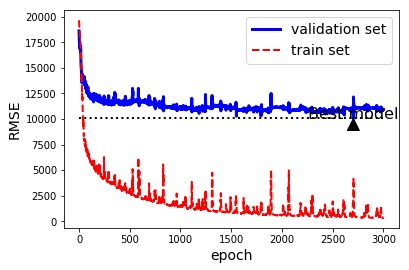

In [46]:
X_train, X_val, y_train, y_val = train_test_split(train_prepared, labels, test_size=0.5, random_state=10)

n_epochs = 3000
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    hist = model.fit(X_train, y_train, epochs=1, batch_size=512)
    y_train_predict = model.predict(X_train)
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
    print("Epoch = %s / 2999 \n" %epoch )

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="train set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

In [47]:
from keras.models import load_model

model.save('my_model.h5')

In [48]:
test_labels = test["산술평균"]
test.drop(["산술평균"], axis=1, inplace=True)

c:\users\student\documents\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [49]:
test_prepared = full_pipeline.fit_transform(test)

print("\n Test Accuracy: %.4f" %(model.evaluate(test_prepared, test_labels)))

3829/3829 [==============================] - 0s 93us/step

 Test Accuracy: 438350575.0891


In [50]:
test_predictions = forest_reg.predict(test_prepared)
forest_mse = mean_squared_error(test_labels, test_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

13341.311512148124

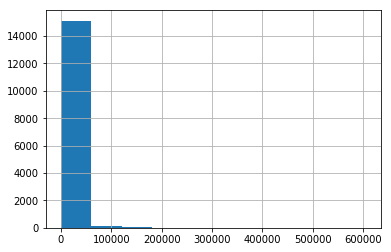

In [52]:
labels.hist()

In [71]:
labels[labels < 100000].describe()

count    15240.000000
mean      7872.466732
std      10626.287229
min        112.000000
25%       2328.500000
50%       4375.000000
75%       8648.500000
max      99864.000000
Name: 산술평균, dtype: float64

In [63]:
data.sort_values(by=['산술평균'],ascending=False).drop(["산업명"], axis=1).head(100)

,회사명,회계년도,소속코드,설립일,종업원,당좌자산(*),재고자산(*),비유동자산(*),유동부채(*),비유동부채(*),...,환율변동으로 인한 차이조정,현금의 증가(감소)(*),기업규모명,산술평균,경제성장률,총저축률,제조업 평균가동률,실업률,코스피지수,경상수지
34321,범양건영(주),2014-03-01,1.0,1958-08-21,139.0,21913712.0,850116.0,12079588.0,10204011.0,5968681.0,...,4418.0,-1163707.0,중소기업,604000.0,1.0,34.1,77.1,3.9,1979.99,12833.0
34322,범양건영(주),2014-06-01,1.0,1958-08-21,139.0,22530152.0,850116.0,11713928.0,14187958.0,6011131.0,...,-4.0,-101930.0,중소기업,604000.0,0.6,34.5,76.3,3.6,1994.96,23792.6
5761,(주)메디톡스,2017-06-01,5.0,2000-05-02,498.0,54035363.0,10489651.0,281859746.0,101396056.0,78848191.0,...,107949.0,994625.0,중소기업,559530.0,0.6,35.7,72.0,3.8,2347.38,14455.0
5762,(주)메디톡스,2017-09-01,5.0,2000-05-02,498.0,49043810.0,12654057.0,298473956.0,128598774.0,51276763.0,...,175377.0,-4911500.0,중소기업,558876.0,1.4,37.0,73.0,3.4,2363.19,25944.5
47821,휴젤(주),2017-09-01,5.0,2001-11-22,353.0,578416617.0,6206514.0,93481030.0,9192975.0,80250220.0,...,0.0,49706927.0,중소기업,547371.0,1.4,37.0,73.0,3.4,2363.19,25944.5
5753,(주)메디톡스,2015-06-01,5.0,2000-05-02,498.0,82961609.0,4331229.0,79707233.0,23029482.0,53238196.0,...,66415.0,4477550.0,중소기업,516368.0,0.4,35.2,73.6,3.8,2114.80,26726.6
47820,휴젤(주),2017-06-01,5.0,2001-11-22,353.0,104012153.0,5984311.0,98665202.0,8112373.0,1257507.0,...,0.0,9328681.0,중소기업,510445.0,0.6,35.7,72.0,3.8,2347.38,14455.0
47822,휴젤(주),2017-12-01,5.0,2001-11-22,353.0,573806032.0,6352555.0,109582741.0,6589735.0,80361065.0,...,0.0,-25566572.0,중소기업,494995.0,-0.2,35.7,71.8,3.2,2476.37,18850.8
5755,(주)메디톡스,2015-12-01,5.0,2000-05-02,498.0,90758339.0,5198780.0,100082470.0,46577153.0,41339102.0,...,413750.0,21192561.0,중소기업,484405.0,0.8,34.9,74.5,3.1,1991.97,27331.2
5763,(주)메디톡스,2017-12-01,5.0,2000-05-02,498.0,71474112.0,10968688.0,290044219.0,135271462.0,47177879.0,...,-449754.0,6022927.0,중소기업,460447.0,-0.2,35.7,71.8,3.2,2476.37,18850.8


In [72]:
data.columns

Index(['회사명', '회계년도', '산업명', '소속코드', '설립일', '종업원', '당좌자산(*)', '재고자산(*)',
       '비유동자산(*)', '유동부채(*)', '비유동부채(*)', '자본금(*)', '자본잉여금(*)', '자본조정(*)',
       '기타포괄손익누계액(*)', '이익잉여금(*)', '매출액(영업수익)(*)', '매출원가(*)', '매출총이익(손실)',
       '판매비와관리비(영업비용)(*)', '영업이익(손실)', '영업외수익(*)', '영업외비용(*)',
       '법인세비용차감전(계속사업)손익', '(계속사업손익)법인세비용', '계속사업이익(손실)', '당기순이익(순손실)',
       '영업활동으로 인한 현금흐름(*)', '투자활동으로 인한 현금흐름(*)', '재무활동으로 인한 현금흐름(*)',
       '환율변동으로 인한 차이조정', '현금의 증가(감소)(*)', '기업규모명', '산술평균', '  경제성장률', '  총저축률',
       '  제조업 평균가동률', '  실업률', ' 코스피지수', '  경상수지'],
      dtype='object')

In [75]:
display(data['산업명'].value_counts().values)

display(data['소속코드'].value_counts())

array([3949, 2088, 1468, 1335, 1207,  984,  838,  709,  665,  589,  521,
        419,  370,  288,  271,  260,  259,  238,  211,  200,  198,  196,
        175,  144,  143,  136,  127,  103,   96,   96,   90,   86,   86,
         75,   71,   67,   50,   46,   42,   34,   34,   28,   28,   27,
         20,   18,   14,   13,   13,   12,    8], dtype=int64)

5.0    15856
1.0     2475
6.0      776
3.0       32
4.0        6
Name: 소속코드, dtype: int64